## Waste Image Classification Project using ConvNeXt Small Model

This project focuses on classifying waste images into different categories using a **ConvNeXt Small** convolutional neural network (CNN). The goal of this project is to demonstrate how modern CNNs can be applied to waste classification tasks, potentially helpful in automated recycling and waste management systems.

The dataset used in this project is the **RealWaste dataset**, which can be found on Kaggle:

- [RealWaste Dataset on Kaggle](https://www.kaggle.com/datasets/joebeachcapital/realwaste)

If you wish to reproduce the results, download the dataset and change the `DATA_DIR` if necessary.

---

### Project Overview

**1. Dataset**  
- The dataset consists of images categorized into 9 waste classes: `Cardboard, Food Organics, Glass, Metal, Miscellaneous Trash, Paper, Plastic, Textile Trash, Vegetation`.  
- A stratified train/validation/test split was applied to ensure balanced class distributions.

**2. Model**  
- A **pretrained ConvNeXt Small model** from TorchVision was used.  
- The backbone was frozen, and only the last stage and classification head were fine-tuned.  
- The classifier head was replaced with a new layer for 9-class classification.

**3. Training**  
- Data augmentation was applied to the training images.  
- Optimization was performed using **AdamW** with weight decay.  
- Label smoothing was used in the cross-entropy loss function.  
- The model was trained for up to 30 epochs, and the best weights were selected based on validation accuracy.

**4. Evaluation**  
- Model performance was measured on the test set using accuracy, confusion matrix, and classification report.  
- Learning curves were plotted to visualize training progress.

---

### 1. Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import random
from PIL import Image

### 2. Configuration

In [2]:
# Fixing a random seed for consistent results
RANDOM_SEED = 42

# Training hyperparameters
BATCH_SIZE = 32
IMG_SIZE = (224, 224) # Required for ConvNeXt input

# Dataset path and class labels
DATA_DIR = "RealWaste"
classes = ["Cardboard", "Food Organics", "Glass", "Metal", "Miscellaneous Trash", "Paper", "Plastic", "Textile Trash", "Vegetation"]

# Device config
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 3. Seed Function

This function ensures reproducibility across Python, NumPy and PyTorch, making this experiment more consistent.

In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    
    # Ensure deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(RANDOM_SEED)

### 4. Data Transforms

Transformations applied to **training** images with augmentation; **validation** and **test** images with no augmentation.

Normalization values are the ImageNet mean/std values, required since we are going to use pretrained model.

In [4]:
# Transformations applied to training images
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Transformations applied to validation and test images
val_test_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### 5. Dataset Distribution Plot

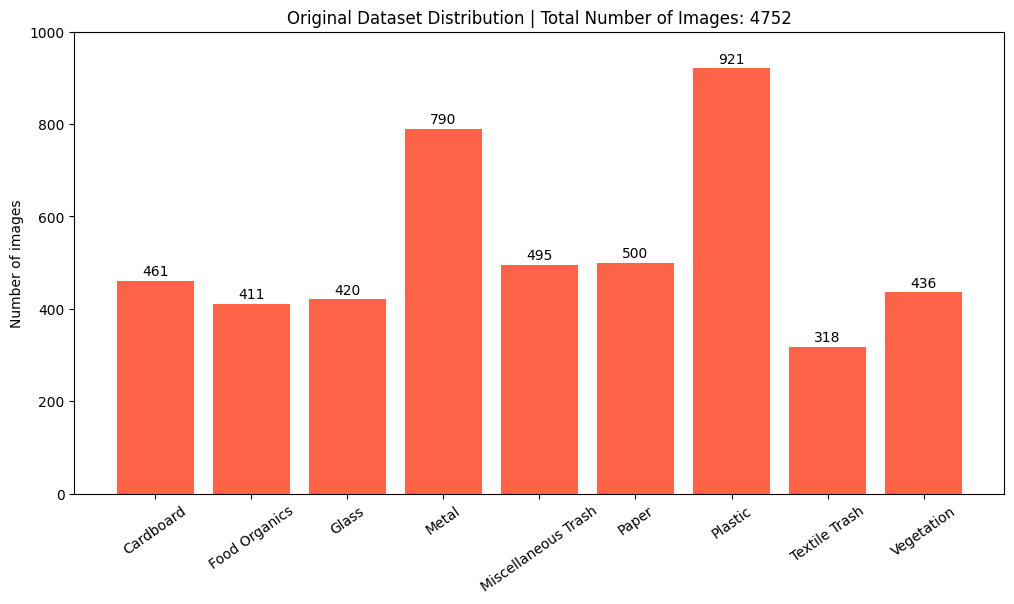

In [5]:
def get_dataset_stats(dataset_path):
    class_counts = {cls: 0 for cls in classes}
    
    for cls in os.listdir(dataset_path):
        cls_path = os.path.join(dataset_path, cls)
        if os.path.isdir(cls_path):
            img_files = [f for f in os.listdir(cls_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            class_counts[cls] = len(img_files)
    return class_counts

def plot_class_distribution(class_counts, title):
    total_images = sum(class_counts.values())
    plt.figure(figsize=(12,6))
    bars = plt.bar(classes, class_counts.values(), color='tomato')
    
    plt.title(f"{title} | Total Number of Images: {total_images}", fontsize=12)
    plt.ylim(0, 1000)
    plt.ylabel("Number of images")
    plt.xticks(rotation=35)
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 5, f"{int(height)}", ha='center', va='bottom', fontsize=10)
    plt.show()

# Show original dataset distribution
original_counts = get_dataset_stats(DATA_DIR)
plot_class_distribution(original_counts, "Original Dataset Distribution")

### 5.1. Sample Images from each Class

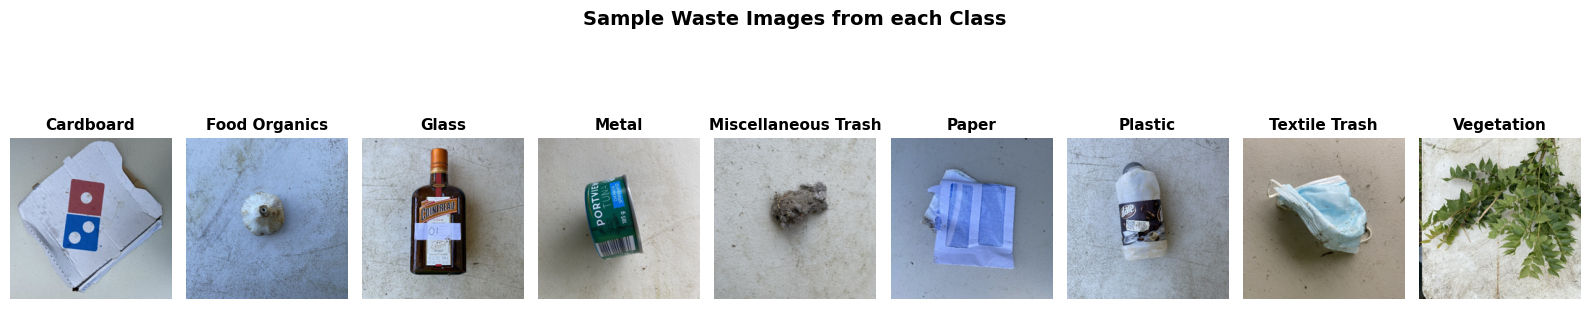

In [6]:
def show_sample_images(base_path, classes, img_size=(224, 224)):
    fig, axes = plt.subplots(1, len(classes), figsize=(16, 4))

    for i, cls in enumerate(classes):
        class_dir = os.path.join(base_path, cls)
        img_file = random.choice(os.listdir(class_dir))
        img_path = os.path.join(class_dir, img_file)

        img = Image.open(img_path)
        img = img.resize(img_size)

        axes[i].imshow(img)
        axes[i].set_title(cls, fontsize=11, fontweight="bold")
        axes[i].axis("off")

    plt.suptitle("Sample Waste Images from each Class", fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.show()

show_sample_images(DATA_DIR, classes)

### 6. Prepare Stratified Train/Val/Test Split

Here, we are using `StratifiedShuffleSplit` to ensure that each subset (train, val, test) keeps the same class proportions as the full dataset, which is important in imbalanced datasets.

In [7]:
# Build mapping
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

# Collect all image paths and labels
image_paths, labels = [], []
for cls in classes:
    cls_idx = class_to_idx[cls]
    cls_dir = os.path.join(DATA_DIR, cls)
    for img_file in os.listdir(cls_dir):
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(cls_dir, img_file))
            labels.append(cls_idx)

# Stratified splitting
# First split: Train (80%) & Temp (20%)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_SEED)
train_idx, temp_idx = next(sss.split(image_paths, labels))

# Second split: Temp (20%) = Validation (10%) + Test (10%)
sss_val = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=RANDOM_SEED)
val_idx, test_idx = next(sss_val.split([image_paths[i] for i in temp_idx], [labels[i] for i in temp_idx]))

# Custom Dataset class
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

# Create dataset objects
train_dataset = CustomImageDataset([image_paths[i] for i in train_idx],
                                   [labels[i] for i in train_idx],
                                   transform=train_transform)

val_dataset = CustomImageDataset([image_paths[temp_idx[i]] for i in val_idx],
                                 [labels[temp_idx[i]] for i in val_idx],
                                 transform=val_test_transform)

test_dataset = CustomImageDataset([image_paths[temp_idx[i]] for i in test_idx],
                                  [labels[temp_idx[i]] for i in test_idx],
                                  transform=val_test_transform)

# Wrap in DataLoader
dataloaders = {
    "train": DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True),
    "val": DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False),
    "test": DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
}

# Class names
class_names = classes
num_classes = len(class_names)

### 7. Pretrained ConvNeXt Small Model Loader

In [8]:
def get_convnext(num_classes):
    model = models.convnext_small(weights=models.ConvNeXt_Small_Weights.DEFAULT)

    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze last stage + classifier
    for name, param in model.named_parameters():
        if "stages.3" in name or "classifier" in name:
            param.requires_grad = True

    # Replace classifier head
    if hasattr(model, "classifier") and isinstance(model.classifier, nn.Sequential):
        in_features = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(in_features, num_classes)
    elif hasattr(model, "head"):  # Fallback for older torchvision
        in_features = model.head.in_features
        model.head = nn.Linear(in_features, num_classes)
    else:
        raise ValueError("Unexpected ConvNeXt architecture")

    return model.to(DEVICE)

### 8. Training Loop

In [9]:
def train_model(model, optimizer, criterion, num_epochs=20):
    
    best_acc = 0.0  # Track best validation accuracy
    best_model_wts = model.state_dict()  # Save best model weights
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(num_epochs):
        model.train()
        train_loss, corrects = 0.0, 0

        # TRAINING LOOP
        for inputs, labels in dataloaders["train"]:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels)

        train_loss /= len(dataloaders["train"].dataset)
        train_acc = corrects.double() / len(dataloaders["train"].dataset)

        # VALIDATION LOOP
        model.eval()
        val_loss, val_corrects = 0.0, 0

        with torch.no_grad():
            for inputs, labels in dataloaders["val"]:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels)

        val_loss /= len(dataloaders["val"].dataset)
        val_acc = val_corrects.double() / len(dataloaders["val"].dataset)

        # Save history
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc.item())
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc.item())

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Load best model weights
    model.load_state_dict(best_model_wts)

    return model, history

### 9. Evaluation Function

In [10]:
def evaluate_model(model):
    model.eval() # Set model to evaluation mode
    y_true, y_pred = [], []
    
    # Collect predictions
    with torch.no_grad():
        for inputs, labels in dataloaders["test"]:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Make sure we only report on classes that actually appear
    unique_labels = sorted(set(y_true) | set(y_pred))

    # Classification report
    print("Classification Report:\n")
    print(classification_report(y_true, y_pred, labels=unique_labels, target_names=[class_names[i] for i in unique_labels], zero_division=0))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=unique_labels)
    plt.figure(figsize=(10,8))
    sns.heatmap(
        cm, annot=True, fmt="d",
        xticklabels=[class_names[i] for i in unique_labels],
        yticklabels=[class_names[i] for i in unique_labels],
        cmap="flare"
    )
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.title("Confusion Matrix")
    plt.show()

    return y_true, y_pred

### 10. Train and Evaluate Model


=== Training ConvNeXt_small ===
Epoch 1/30 | Train Loss: 1.2953, Train Acc: 0.6709, Val Loss: 0.9819, Val Acc: 0.8000
Epoch 2/30 | Train Loss: 0.9656, Train Acc: 0.8108, Val Loss: 0.9027, Val Acc: 0.8589
Epoch 3/30 | Train Loss: 0.9115, Train Acc: 0.8390, Val Loss: 0.8824, Val Acc: 0.8589
Epoch 4/30 | Train Loss: 0.8809, Train Acc: 0.8535, Val Loss: 0.8678, Val Acc: 0.8653
Epoch 5/30 | Train Loss: 0.8552, Train Acc: 0.8598, Val Loss: 0.8616, Val Acc: 0.8611
Epoch 6/30 | Train Loss: 0.8599, Train Acc: 0.8614, Val Loss: 0.8470, Val Acc: 0.8737
Epoch 7/30 | Train Loss: 0.8552, Train Acc: 0.8653, Val Loss: 0.8305, Val Acc: 0.8800
Epoch 8/30 | Train Loss: 0.8251, Train Acc: 0.8750, Val Loss: 0.8199, Val Acc: 0.8863
Epoch 9/30 | Train Loss: 0.8365, Train Acc: 0.8745, Val Loss: 0.8185, Val Acc: 0.8989
Epoch 10/30 | Train Loss: 0.8165, Train Acc: 0.8816, Val Loss: 0.8212, Val Acc: 0.8947
Epoch 11/30 | Train Loss: 0.8239, Train Acc: 0.8779, Val Loss: 0.8223, Val Acc: 0.8947
Epoch 12/30 | Train

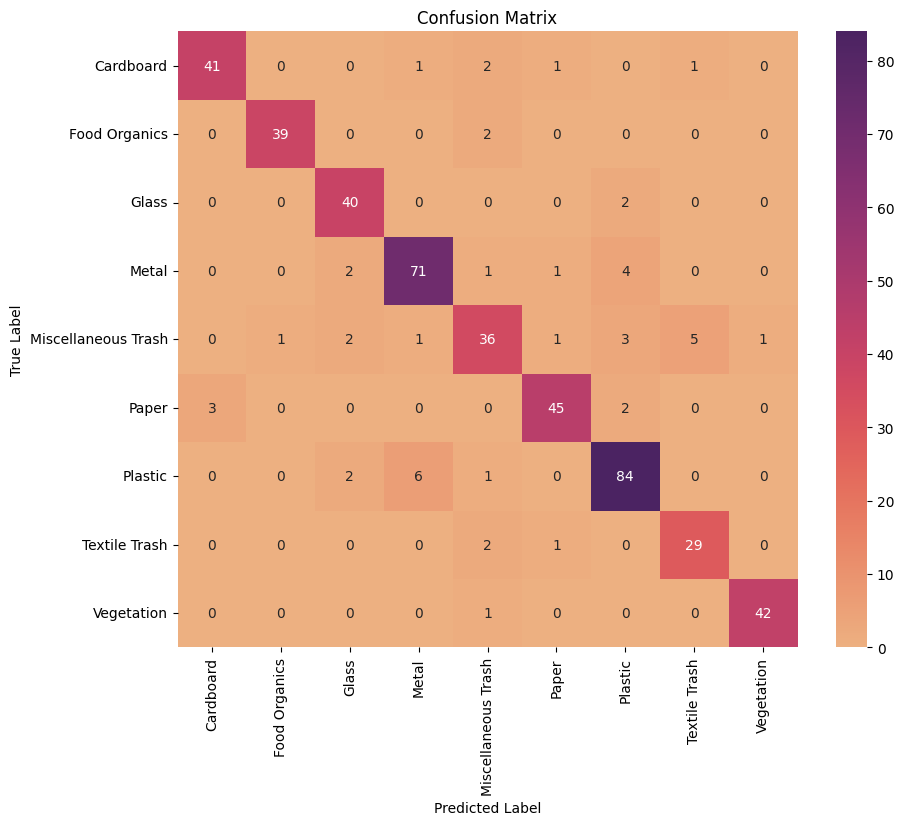

In [11]:
# Number of epochs
NUM_EPOCHS = 30

# Loss function
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

print("\n=== Training ConvNeXt_small ===")

# Load the pretrained ConvNeXt with frozen backbone and new head
model = get_convnext(num_classes)

# AdamW optimizer
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, weight_decay=1e-4)

# Train model
model, history = train_model(model, optimizer, criterion, num_epochs=NUM_EPOCHS)

# Evaluate model on test set
print("\nEvaluation for ConvNeXt_small")
y_true, y_pred = evaluate_model(model)

# Compute overall test accuracy
final_accuracy = sum(np.array(y_true) == np.array(y_pred)) / len(y_true)

### 11. Plot Learning Curve

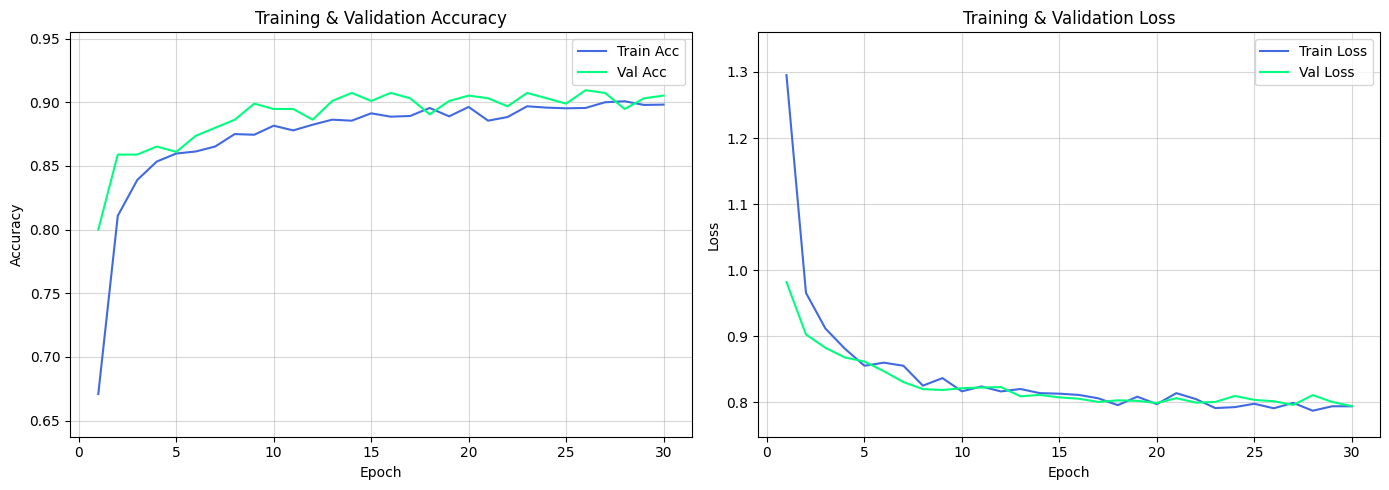

In [12]:
def plot_training_curves(history):
    epochs = range(1, len(history['train_loss']) + 1)
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy subplot
    axs[0].plot(epochs, history['train_acc'], label='Train Acc', color='royalblue')
    axs[0].plot(epochs, history['val_acc'], label='Val Acc', color='springgreen')
    axs[0].set_title("Training & Validation Accuracy")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend()
    axs[0].grid(True, alpha=0.5)
    axs[0].set_ylim(min(min(history['train_acc']), min(history['val_acc'])) * 0.95,
                    max(max(history['train_acc']), max(history['val_acc'])) * 1.05)

    # Loss subplot
    axs[1].plot(epochs, history['train_loss'], label='Train Loss', color='royalblue')
    axs[1].plot(epochs, history['val_loss'], label='Val Loss', color='springgreen')
    axs[1].set_title("Training & Validation Loss")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Loss")
    axs[1].legend()
    axs[1].grid(True, alpha=0.5)
    axs[1].set_ylim(min(min(history['train_loss']), min(history['val_loss'])) * 0.95,
                    max(max(history['train_loss']), max(history['val_loss'])) * 1.05)

    plt.tight_layout()
    plt.show()

plot_training_curves(history)

### 12. Final Accuracy Bar Plot

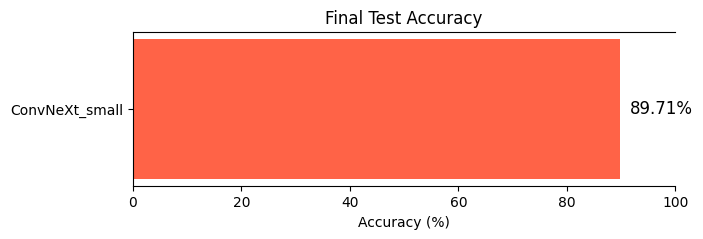

In [13]:
final_acc_percent = final_accuracy * 100

plt.figure(figsize=(7,2))
plt.barh(["ConvNeXt_small"], [final_acc_percent], color="tomato")
plt.gca().spines['right'].set_visible(False)
plt.xlim(0, 100)
plt.xlabel("Accuracy (%)")
plt.title("Final Test Accuracy")
plt.text(final_acc_percent + 2, 0, f"{final_acc_percent:.2f}%", va='center', fontsize=12)
plt.show()